## Basical settings

Import packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder
import multiprocessing
import time
import torch

import utils

# for testing purpose
import importlib

plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# !nvidia-smi
print(torch.__version__)
print(torch.cuda.is_available())

Global variables

In [ ]:
wavelengths = np.arange(400, 800)*u.nm
FWHM        = 0.5
lambda_Na   = 589.0*u.nm
lambda_Mg   = 518.3*u.nm
width       = 1000
height      = 1500

dir='./dataset/'
os.makedirs(dir, exist_ok=True)

## Generate dataset (Skip this block)

Define the function to generate the image use our pre-defined functions. 

In [16]:
def generate_dataset(num_images, dir='./dataset/'): 
    '''
    generate the image and save the images in the directory. 
    Args: 
        num_images  
        dir
    Output: 
        JPG files and a json file in COCO format in the directory
    No return
    NOTE: returns an image for testing
    '''
    # TODO: check if the directory is usable
    # customized variables applying to all images
    # TODO: if exception
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    anno_id_start = 1# max([i['id'] for i in labels['annotations']]) + 1
    anno_id = anno_id_start
    image_id_start = 1# max([i['id'] for i in labels['images']]) + 1

    # Loop to generate images
    for image_id in range(image_id_start, image_id_start + num_images): 
        filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
        print('generating image: %s...'%filename)
        # parameters
        num_stars       = 200
        x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # TODO: change the border where the meteor can show
        num_meteors     = 20
        length_meteors  = (np.random.rand(num_meteors)*500).astype(np.int16)                      # pixel
        x_meteors       = (np.random.rand(num_meteors)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_meteors       = (np.random.rand(num_meteors)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # image - parameters needed for `generate_image` function
        coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
        amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
        T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
        coord_meteors   = np.array([x_meteors, y_meteors]).T        # [n, 2]pixel
        amp_meteors     = np.random.rand(num_meteors)*1e8           # [n]erg -> pixel value
        T_meteors       = [2000*u.K]*num_meteors                    # [n]5000K-20000K
        angle_meteors   = np.random.rand(num_meteors)*2*np.pi       # [n]radian
        angle_slit      = np.random.rand()*2*np.pi                  # radian
        length_slit     = 100
        # generate image
        image = utils.generate_image(coord_stars, amp_stars, T_stars, coord_meteors, amp_meteors, T_meteors, 
                               angle_meteors, length_meteors, angle_slit, length_slit)
        image8 = image.astype(np.uint8)-1
        im = Image.fromarray(image8)
        im.save(os.path.join(dir, filename), quality=100)
        # label - image
        label_image = utils.annotate_image(filename, image_id)
        labels['images'].append(label_image)
        # label - annotation - meteor
        for [x_meteor, y_meteor], angle_meteor, length_meteor in zip(coord_meteors, angle_meteors, length_meteors):
            label_meteor = utils.annotate_meteor(x_meteor, y_meteor, angle_slit, length_slit, angle_meteor, 
                                                  length_meteor, anno_id, image_id)
            labels['annotations'].append(label_meteor)
            anno_id += 1
        # label - annotation - stars
        for x, y in coord_stars: 
            label_star = utils.annotate_star(x, y, angle_slit, length_slit, anno_id, image_id)
            if label_star != None: 
                labels['annotations'].append(label_star)
                anno_id += 1
        # rewrite json file everytime finishing generating an image
        with open(os.path.join(dir, 'labels.json'), 'w') as f:
            json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    
    return image, labels


Generate the dataset. 

generating image: 1_20230305-023456.jpg...
generating image: 2_20230305-023513.jpg...
generating image: 3_20230305-023531.jpg...
generating image: 4_20230305-023551.jpg...
generating image: 5_20230305-023608.jpg...
generating image: 6_20230305-023627.jpg...
generating image: 7_20230305-023647.jpg...
generating image: 8_20230305-023701.jpg...
generating image: 9_20230305-023718.jpg...
generating image: 10_20230305-023737.jpg...


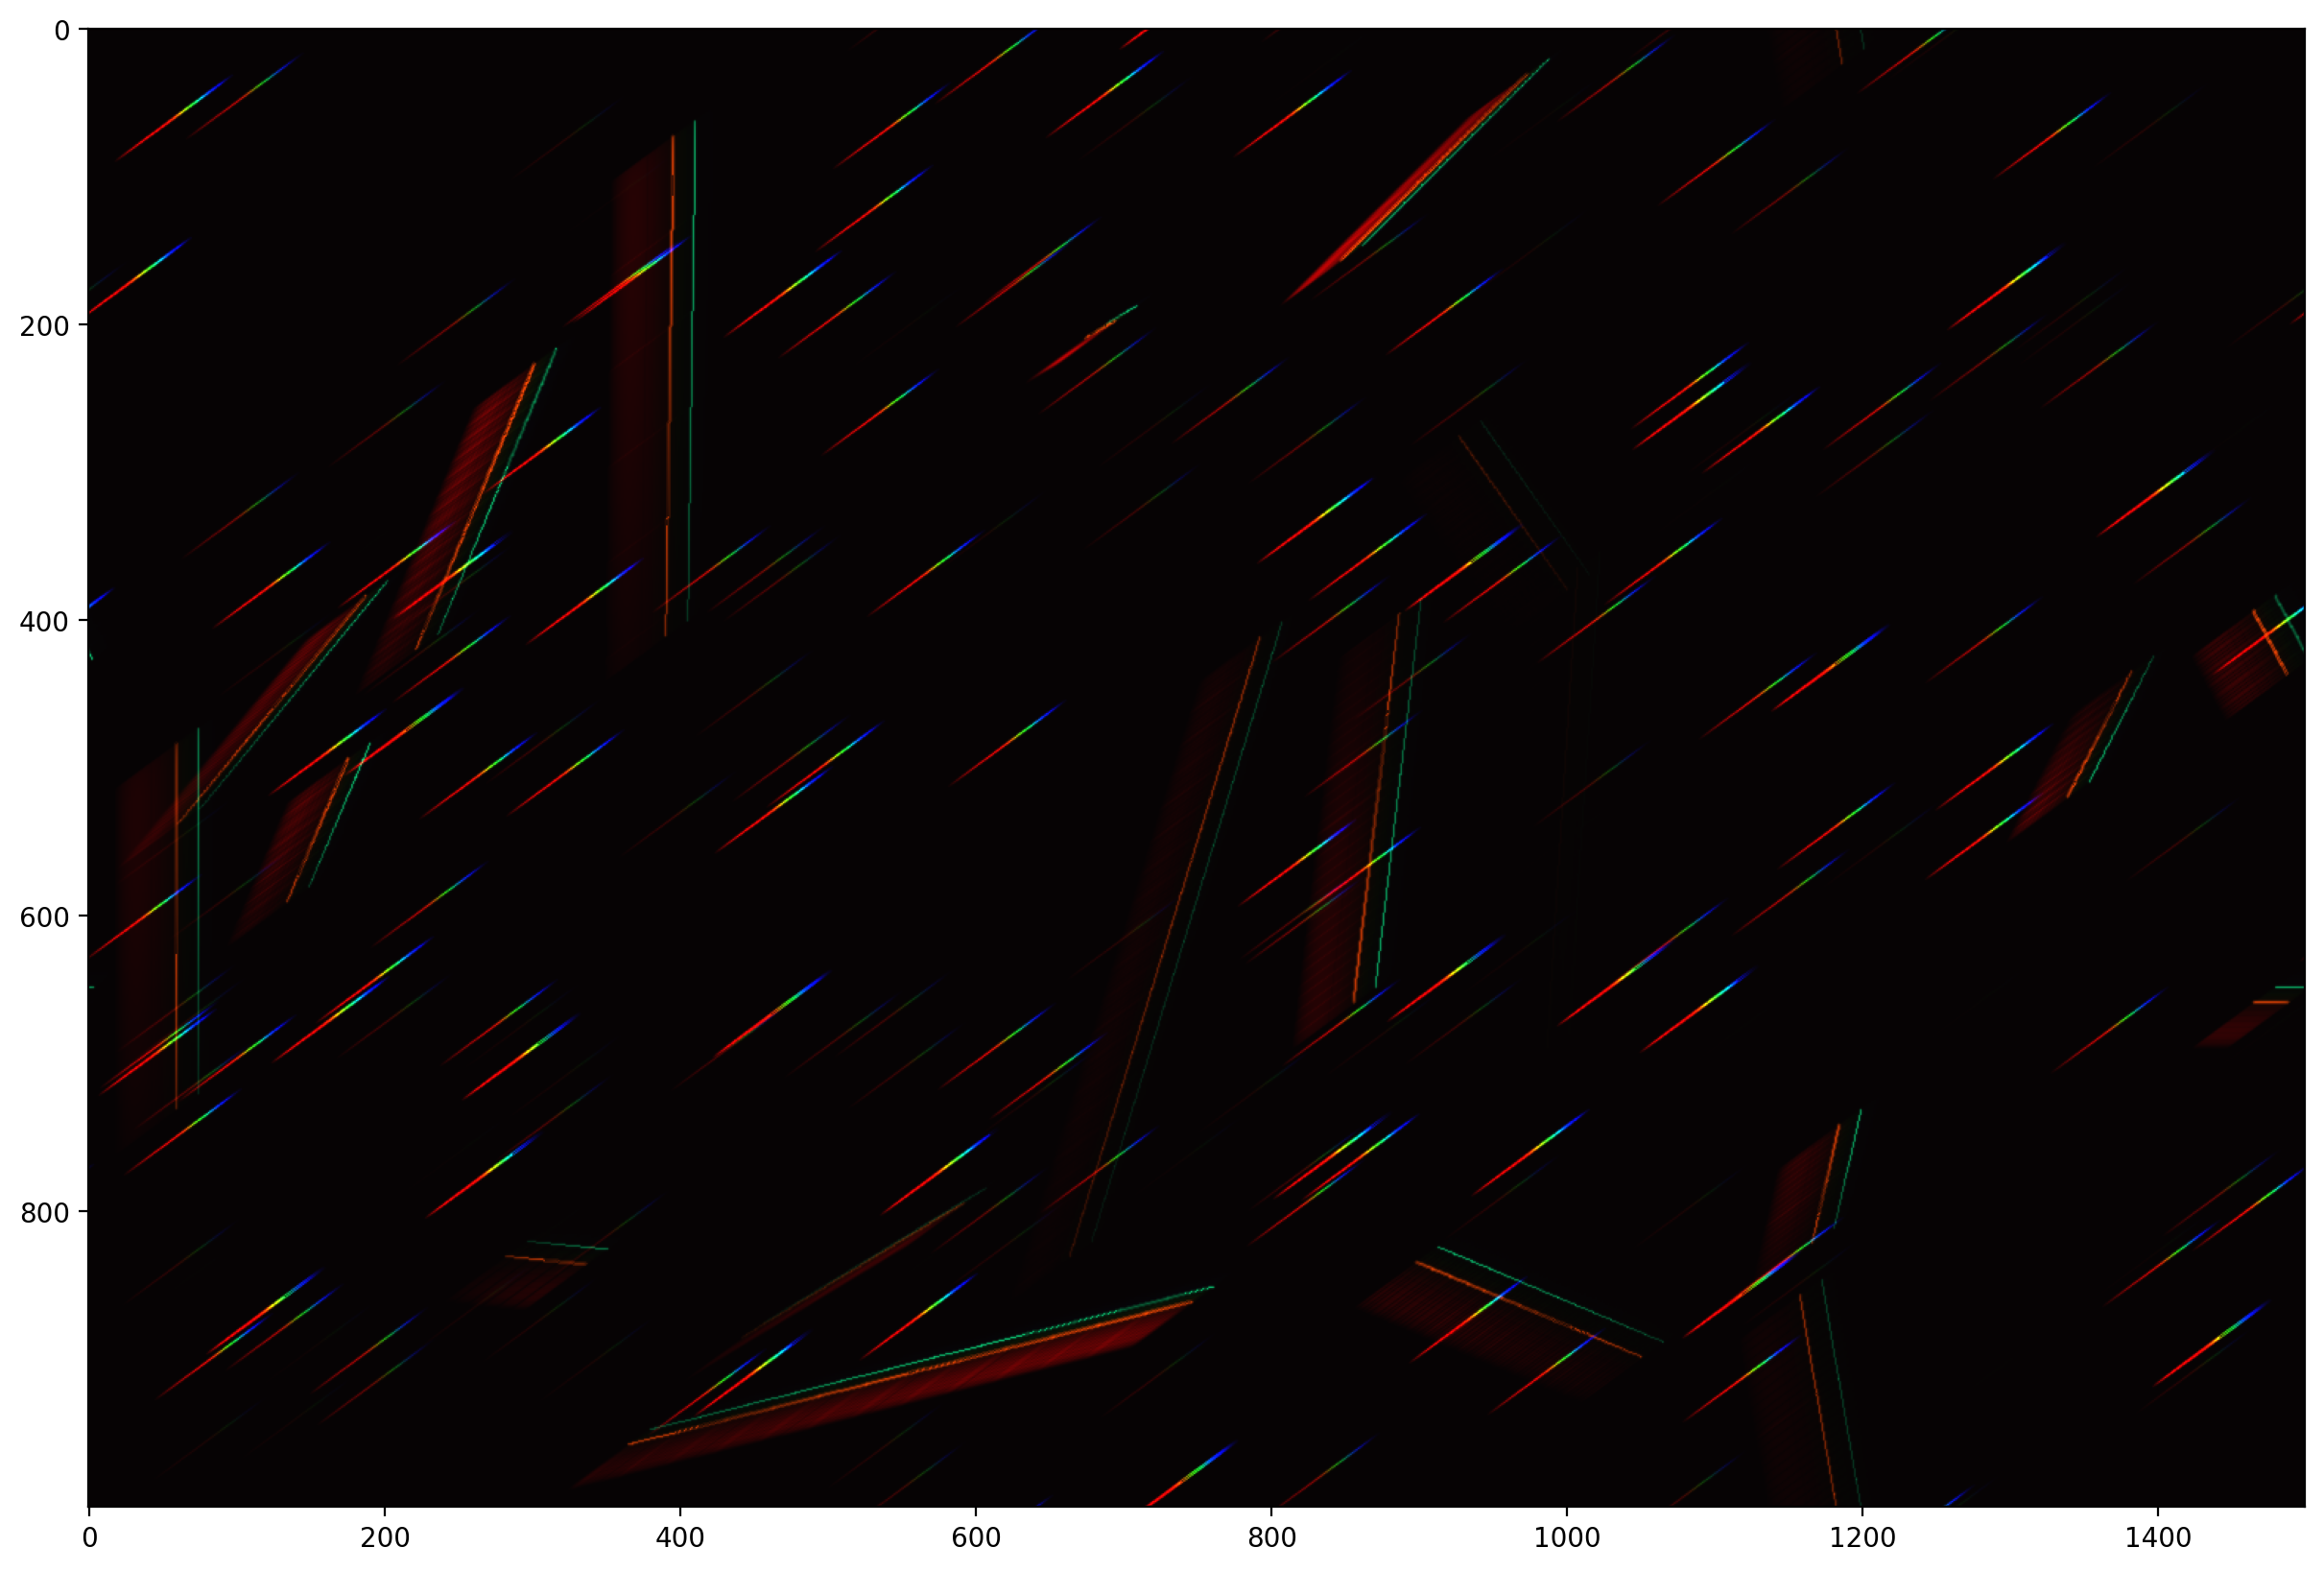

In [18]:
labels = utils.blank_label()
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 8
image, labels = generate_dataset(num_images, dir)

plt.figure(figsize=[15, 10])
plt.imshow(image)
plt.show()

## Generate dataset using multiprocessing: 

In [21]:
def generate_singledata(image_id): 
    '''
    '''
    filename = str(image_id) + "_" + time.strftime("%Y%m%d-%H%M%S") + ".jpg"
    print('generating image: %s...'%filename)
    # parameters
    num_stars       = 200
    x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
    y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
    # TODO: change the border where the meteor can show
    num_meteors     = 20
    length_meteors  = (np.random.rand(num_meteors)*500).astype(np.int16)                      # pixel
    x_meteors       = (np.random.rand(num_meteors)*(width-10*FWHM)+5*FWHM).astype(np.int16)
    y_meteors       = (np.random.rand(num_meteors)*(height-10*FWHM)+5*FWHM).astype(np.int16)
    # image - parameters needed for `generate_image` function
    coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
    amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
    T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
    coord_meteors   = np.array([x_meteors, y_meteors]).T        # [n, 2]pixel
    amp_meteors     = np.random.rand(num_meteors)*1e8           # [n]erg -> pixel value
    T_meteors       = [2000*u.K]*num_meteors                    # [n]5000K-20000K
    angle_meteors   = np.random.rand(num_meteors)*2*np.pi       # [n]radian
    angle_slit      = np.random.rand()*2*np.pi                  # radian
    length_slit     = 100
    # generate image
    image = utils.generate_image(coord_stars, amp_stars, T_stars, coord_meteors, amp_meteors, T_meteors, 
                            angle_meteors, length_meteors, angle_slit, length_slit)
    image8 = image.astype(np.uint8)-1
    im = Image.fromarray(image8)
    im.save(os.path.join(dir, filename), quality=100)
    # label - image
    label = {'images': [], 'annotations': []}
    label_image = utils.annotate_image(filename, image_id)
    label['images'].append(label_image)
    # label - annotation - meteor
    for [x_meteor, y_meteor], angle_meteor, length_meteor in zip(coord_meteors, angle_meteors, length_meteors):
        label_meteor = utils.annotate_meteor(x_meteor, y_meteor, angle_slit, length_slit, angle_meteor, 
                                                length_meteor, anno_id_shared.value, image_id)
        label['annotations'].append(label_meteor)
        anno_id_shared.value += 1
    # label - annotation - stars
    for x, y in coord_stars: 
        label_star = utils.annotate_star(x, y, angle_slit, length_slit, anno_id_shared.value, image_id)
        if label_star != None: 
            label['annotations'].append(label_star)
            anno_id_shared.value += 1
    # rewrite json file everytime finishing generating an image
    lock.acquire()
    labels = json.load(open(os.path.join(dir, 'labels.json'), 'r'))
    labels.update(label)
    with open(os.path.join(dir, 'labels.json'), 'w') as f:
        json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    lock.release()

In [22]:
labels = utils.blank_label()
with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)

num_images = 10


anno_id_start = 1# max([i['id'] for i in labels['annotations']]) + 1
anno_id = anno_id_start
image_id_start = 1# max([i['id'] for i in labels['images']]) + 1

manager = multiprocessing.Manager()
anno_id_shared = manager.Value('i', anno_id)
lock = multiprocessing.RLock()
args = zip(range(image_id_start, image_id_start + num_images))
with multiprocessing.Pool(processes=4) as pool:
    results = pool.starmap(generate_singledata, args)

generating image: 1_20230305-024311.jpg...generating image: 2_20230305-024311.jpg...

generating image: 3_20230305-024311.jpg...
generating image: 4_20230305-024311.jpg...
generating image: 5_20230305-024351.jpg...
generating image: 6_20230305-024352.jpg...
generating image: 7_20230305-024353.jpg...
generating image: 8_20230305-024353.jpg...
generating image: 9_20230305-024413.jpg...
generating image: 10_20230305-024416.jpg...


In [14]:
importlib.reload(utils)

<module 'utils' from '/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/Meteor spectrum/Metspec/utils.py'>